2025-08-26 01:50:51.718950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756173051.922169      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756173051.979323      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of features used: 810
Train shape: (489, 810), Val shape: (56, 810), Test shape: (56, 810)


I0000 00:00:1756173063.824325      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756173063.824999      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1756173067.961456      62 service.cc:148] XLA service 0x7e8440008280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756173067.961947      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756173067.961971      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756173068.254734      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756173070.123098      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 - 7s - 459ms/step - loss: 81.2429 - mae: 6.7669 - val_loss: 63.1715 - val_mae: 5.8962
Epoch 2/100
16/16 - 0s - 7ms/step - loss: 78.0411 - mae: 6.6424 - val_loss: 81.4000 - val_mae: 7.0006
Epoch 3/100
16/16 - 0s - 6ms/step - loss: 72.8038 - mae: 6.4730 - val_loss: 120.0794 - val_mae: 9.1622
Epoch 4/100
16/16 - 0s - 6ms/step - loss: 68.7667 - mae: 6.5168 - val_loss: 127.6747 - val_mae: 9.5299
Epoch 5/100
16/16 - 0s - 7ms/step - loss: 63.4251 - mae: 6.2402 - val_loss: 140.8058 - val_mae: 10.1633
Epoch 6/100
16/16 - 0s - 6ms/step - loss: 56.4806 - mae: 6.0148 - val_loss: 80.1460 - val_mae: 6.9612
Epoch 7/100
16/16 - 0s - 6ms/step - loss: 52.9326 - mae: 5.8104 - val_loss: 100.5560 - val_mae: 8.0919
Epoch 8/100
16/16 - 0s - 7ms/step - loss: 47.5000 - mae: 5.6228 - val_loss: 62.7439 - val_mae: 6.0481
Epoch 9/100
16/16 - 0s - 6ms/step - loss: 43.3456 - mae: 5.4322 - val_loss: 88.3176 - val_mae: 7.4614
Epoch 10/100
16/16 - 0s - 6ms/step - loss: 38.6573 - mae: 5.0746 - val_loss: 87.6075 - 

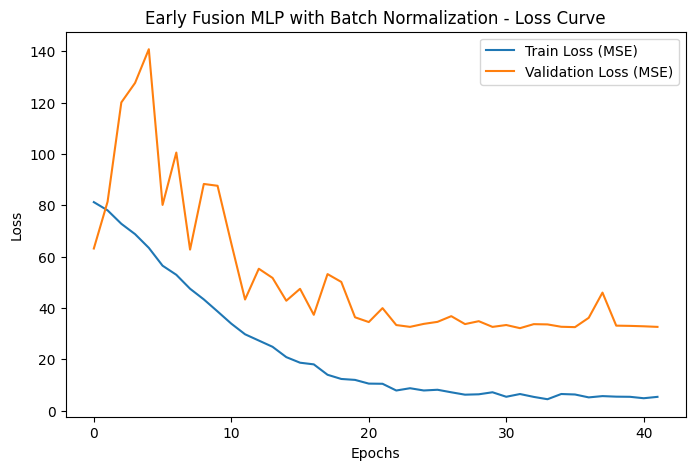

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Paths to your data files (update these if needed)
audio_train_path = '/kaggle/input/features/train_audio_features_normalized (1).csv'
text_train_path = '/kaggle/input/features/train_standardized.csv'
audio_dev_path = '/kaggle/input/features/fixed_dev_audio_features.csv'
text_dev_path = '/kaggle/input/features/dev_standardized.csv'
audio_test_path = '/kaggle/input/features/fixed_test_audio_features.csv'
text_test_path = '/kaggle/input/features/test_standardized.csv'

# Load CSVs
audio_train = pd.read_csv(audio_train_path)
text_train = pd.read_csv(text_train_path)
audio_dev = pd.read_csv(audio_dev_path)
text_dev = pd.read_csv(text_dev_path)
audio_test = pd.read_csv(audio_test_path)
text_test = pd.read_csv(text_test_path)

# Merge audio and text features on filename
train = pd.merge(audio_train, text_train, on='filename', suffixes=('_audio', '_text'))
dev = pd.merge(audio_dev, text_dev, on='filename', suffixes=('_audio', '_text'))
test = pd.merge(audio_test, text_test, on='filename', suffixes=('_audio', '_text'))

# Identify label columns dynamically
all_label_cols = [col for col in train.columns if 'label' in col]

# Exclude filename and all label columns from features
exclude_cols = ['filename'] + all_label_cols

# Find intersection of columns across train, dev, and test for consistent features
train_cols = set(train.columns)
dev_cols = set(dev.columns)
test_cols = set(test.columns)

common_cols = train_cols & dev_cols & test_cols
feature_cols = [col for col in common_cols if col not in exclude_cols]

print(f"Number of features used: {len(feature_cols)}")

# Prepare feature arrays and labels
X_train = train[feature_cols].values
y_train = train[all_label_cols[0]].values

X_val = dev[feature_cols].values
y_val = dev[all_label_cols[0]].values

X_test = test[feature_cols].values
y_test = test[all_label_cols[0]].values

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# Build the MLP model with Batch Normalization and Input layer
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, use_bias=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, use_bias=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, use_bias=False),
    BatchNormalization(),
    # Output layer does not need batch norm
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Set early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Plot training and validation loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Early Fusion MLP with Batch Normalization - Loss Curve')
plt.legend()
plt.show()


Audio train shape: (489, 0)
Text train shape: (489, 0)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16/16 - 9s - 579ms/step - loss: 81.4171 - mae: 6.6635 - val_loss: 75.0592 - val_mae: 6.5428
Epoch 2/100
16/16 - 0s - 8ms/step - loss: 81.2107 - mae: 6.6523 - val_loss: 74.8502 - val_mae: 6.5319
Epoch 3/100
16/16 - 0s - 7ms/step - loss: 80.9990 - mae: 6.6415 - val_loss: 74.6478 - val_mae: 6.5214
Epoch 4/100
16/16 - 0s - 7ms/step - loss: 80.7945 - mae: 6.6305 - val_loss: 74.4473 - val_mae: 6.5109
Epoch 5/100
16/16 - 0s - 7ms/step - loss: 80.5886 - mae: 6.6195 - val_loss: 74.2466 - val_mae: 6.5004
Epoch 6/100
16/16 - 0s - 8ms/step - loss: 80.3840 - mae: 6.6083 - val_loss: 74.0416 - val_mae: 6.4896
Epoch 7/100
16/16 - 0s - 7ms/step - loss: 80.1749 - mae: 6.5972 - val_loss: 73.8426 - val_mae: 6.4792
Epoch 8/100
16/16 - 0s - 7ms/step - loss: 79.9741 - mae: 6.5863 - val_loss: 73.6380 - val_mae: 6.4684
Epoch 9/100
16/16 - 0s - 7ms/step - loss: 79.7683 - mae: 6.5753 - val_loss: 73.4397 - val_mae: 6.4579
Epoch 10/100
16/16 - 0s - 7ms/step - loss: 79.5658 - mae: 6.5644 - val_loss: 73.2397 - val_m

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
Test MSE: 84.5057
Test MAE: 7.0555
Test R2: -1.0018


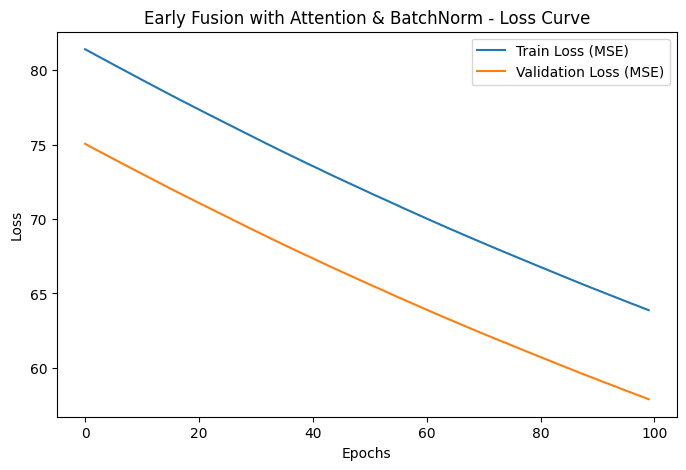

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Attention, Flatten, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Paths to your data files (update these if needed)
audio_train_path = '/kaggle/input/features/train_audio_features_normalized (1).csv'
text_train_path = '/kaggle/input/features/train_standardized.csv'
audio_dev_path = '/kaggle/input/features/fixed_dev_audio_features.csv'
text_dev_path = '/kaggle/input/features/dev_standardized.csv'
audio_test_path = '/kaggle/input/features/fixed_test_audio_features.csv'
text_test_path = '/kaggle/input/features/test_standardized.csv'

# Load CSVs
audio_train = pd.read_csv(audio_train_path)
text_train = pd.read_csv(text_train_path)
audio_dev = pd.read_csv(audio_dev_path)
text_dev = pd.read_csv(text_dev_path)
audio_test = pd.read_csv(audio_test_path)
text_test = pd.read_csv(text_test_path)

# Merge on filename
train = pd.merge(audio_train, text_train, on='filename', suffixes=('_audio', '_text'))
dev = pd.merge(audio_dev, text_dev, on='filename', suffixes=('_audio', '_text'))
test = pd.merge(audio_test, text_test, on='filename', suffixes=('_audio', '_text'))

# Identify label columns dynamically
all_label_cols = [col for col in train.columns if 'label' in col]
exclude_cols = ['filename'] + all_label_cols

train_cols = set(train.columns)
dev_cols = set(dev.columns)
test_cols = set(test.columns)

common_cols = train_cols & dev_cols & test_cols
feature_cols = [col for col in common_cols if col not in exclude_cols]

# Split audio and text feature columns by suffix
audio_feature_cols = [col for col in feature_cols if col.endswith('_audio')]
text_feature_cols = [col for col in feature_cols if col.endswith('_text')]

X_audio_train = train[audio_feature_cols].values
X_text_train = train[text_feature_cols].values
y_train = train[all_label_cols[0]].values

X_audio_val = dev[audio_feature_cols].values
X_text_val = dev[text_feature_cols].values
y_val = dev[all_label_cols[0]].values

X_audio_test = test[audio_feature_cols].values
X_text_test = test[text_feature_cols].values
y_test = test[all_label_cols[0]].values

print(f"Audio train shape: {X_audio_train.shape}")
print(f"Text train shape: {X_text_train.shape}")

# Build model with attention mechanism for early fusion and batch normalization

# Audio input branch
audio_input = Input(shape=(X_audio_train.shape[1],), name='audio_input')
audio_dense = Dense(128, use_bias=False)(audio_input)
audio_dense = BatchNormalization()(audio_dense)
audio_dense = tf.keras.layers.Activation('relu')(audio_dense)
audio_dense = Dense(64, use_bias=False)(audio_dense)
audio_dense = BatchNormalization()(audio_dense)
audio_dense = tf.keras.layers.Activation('relu')(audio_dense)
audio_reshaped = Reshape((1, 64))(audio_dense)

# Text input branch
text_input = Input(shape=(X_text_train.shape[1],), name='text_input')
text_dense = Dense(128, use_bias=False)(text_input)
text_dense = BatchNormalization()(text_dense)
text_dense = tf.keras.layers.Activation('relu')(text_dense)
text_dense = Dense(64, use_bias=False)(text_dense)
text_dense = BatchNormalization()(text_dense)
text_dense = tf.keras.layers.Activation('relu')(text_dense)
text_reshaped = Reshape((1, 64))(text_dense)

# Attention layer - query=audio, value=text (you can swap as needed)
attention_out = Attention()([audio_reshaped, text_reshaped])  # output shape (batch, 1, feature_dim)
flattened = Flatten()(attention_out)

# Final regression head
x = Dense(64, use_bias=False)(flattened)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, use_bias=False)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    [X_audio_train, X_text_train], y_train,
    validation_data=([X_audio_val, X_text_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
y_pred = model.predict([X_audio_test, X_text_test])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Early Fusion with Attention & BatchNorm - Loss Curve')
plt.legend()
plt.show()


Audio train shape: (489, 0), Text train shape: (489, 0)
Epoch 1/100
16/16 - 8s - 526ms/step - loss: 81.4186 - mae: 6.6635 - val_loss: 75.0585 - val_mae: 6.5427
Epoch 2/100
16/16 - 0s - 8ms/step - loss: 81.2053 - mae: 6.6524 - val_loss: 74.8508 - val_mae: 6.5319
Epoch 3/100
16/16 - 0s - 7ms/step - loss: 80.9971 - mae: 6.6415 - val_loss: 74.6431 - val_mae: 6.5211
Epoch 4/100
16/16 - 0s - 7ms/step - loss: 80.7872 - mae: 6.6298 - val_loss: 74.4440 - val_mae: 6.5107
Epoch 5/100
16/16 - 0s - 7ms/step - loss: 80.5828 - mae: 6.6192 - val_loss: 74.2389 - val_mae: 6.5000
Epoch 6/100
16/16 - 0s - 7ms/step - loss: 80.3782 - mae: 6.6081 - val_loss: 74.0357 - val_mae: 6.4893
Epoch 7/100
16/16 - 0s - 7ms/step - loss: 80.1729 - mae: 6.5972 - val_loss: 73.8362 - val_mae: 6.4788
Epoch 8/100
16/16 - 0s - 7ms/step - loss: 79.9681 - mae: 6.5860 - val_loss: 73.6379 - val_mae: 6.4684
Epoch 9/100
16/16 - 0s - 7ms/step - loss: 79.7661 - mae: 6.5754 - val_loss: 73.4367 - val_mae: 6.4577
Epoch 10/100
16/16 - 0s 

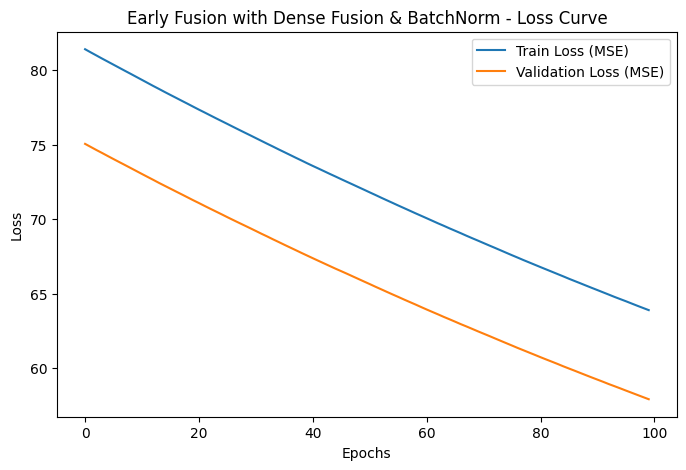

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Paths to data files
audio_train_path = '/kaggle/input/features/train_audio_features_normalized (1).csv'
text_train_path = '/kaggle/input/features/train_standardized.csv'
audio_dev_path = '/kaggle/input/features/fixed_dev_audio_features.csv'
text_dev_path = '/kaggle/input/features/dev_standardized.csv'
audio_test_path = '/kaggle/input/features/fixed_test_audio_features.csv'
text_test_path = '/kaggle/input/features/test_standardized.csv'

# Load dataframes
audio_train = pd.read_csv(audio_train_path)
text_train = pd.read_csv(text_train_path)
audio_dev = pd.read_csv(audio_dev_path)
text_dev = pd.read_csv(text_dev_path)
audio_test = pd.read_csv(audio_test_path)
text_test = pd.read_csv(text_test_path)

# Merge audio and text on filename
train = pd.merge(audio_train, text_train, on='filename', suffixes=('_audio', '_text'))
dev = pd.merge(audio_dev, text_dev, on='filename', suffixes=('_audio', '_text'))
test = pd.merge(audio_test, text_test, on='filename', suffixes=('_audio', '_text'))

all_label_cols = [col for col in train.columns if 'label' in col]
exclude_cols = ['filename'] + all_label_cols

train_cols = set(train.columns)
dev_cols = set(dev.columns)
test_cols = set(test.columns)
common_cols = train_cols & dev_cols & test_cols
feature_cols = [col for col in common_cols if col not in exclude_cols]

audio_feature_cols = [col for col in feature_cols if col.endswith('_audio')]
text_feature_cols = [col for col in feature_cols if col.endswith('_text')]

# Prepare arrays
X_audio_train = train[audio_feature_cols].values
X_text_train = train[text_feature_cols].values
y_train = train[all_label_cols[0]].values

X_audio_val = dev[audio_feature_cols].values
X_text_val = dev[text_feature_cols].values
y_val = dev[all_label_cols[0]].values

X_audio_test = test[audio_feature_cols].values
X_text_test = test[text_feature_cols].values
y_test = test[all_label_cols[0]].values

print(f"Audio train shape: {X_audio_train.shape}, Text train shape: {X_text_train.shape}")

# Define model with fusion dense layer and batch normalization

# Audio branch
audio_input = Input(shape=(X_audio_train.shape[1],), name='audio_input')
x_audio = Dense(128, use_bias=False)(audio_input)
x_audio = BatchNormalization()(x_audio)
x_audio = Activation('relu')(x_audio)
x_audio = Dense(64, use_bias=False)(x_audio)
x_audio = BatchNormalization()(x_audio)
x_audio = Activation('relu')(x_audio)

# Text branch
text_input = Input(shape=(X_text_train.shape[1],), name='text_input')
x_text = Dense(128, use_bias=False)(text_input)
x_text = BatchNormalization()(x_text)
x_text = Activation('relu')(x_text)
x_text = Dense(64, use_bias=False)(x_text)
x_text = BatchNormalization()(x_text)
x_text = Activation('relu')(x_text)

# Fusion layer: concatenate audio and text intermediate outputs
fusion = Concatenate()([x_audio, x_text])  # shape: (batch_size, 128)

# Fusion Dense layers
x = Dense(64, use_bias=False)(fusion)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Final regression output
output = Dense(1, activation='linear')(x)

model = Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    [X_audio_train, X_text_train], y_train,
    validation_data=([X_audio_val, X_text_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate model
y_pred = model.predict([X_audio_test, X_text_test])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Early Fusion with Dense Fusion & BatchNorm - Loss Curve')
plt.legend()
plt.show()


Epoch 1/100
16/16 - 2s - 139ms/step - loss: 81.4189 - val_loss: 75.0598
Epoch 2/100
16/16 - 0s - 6ms/step - loss: 81.2113 - val_loss: 74.8530
Epoch 3/100
16/16 - 0s - 6ms/step - loss: 80.9991 - val_loss: 74.6518
Epoch 4/100
16/16 - 0s - 6ms/step - loss: 80.7953 - val_loss: 74.4454
Epoch 5/100
16/16 - 0s - 6ms/step - loss: 80.5856 - val_loss: 74.2446
Epoch 6/100
16/16 - 0s - 6ms/step - loss: 80.3790 - val_loss: 74.0405
Epoch 7/100
16/16 - 0s - 6ms/step - loss: 80.1741 - val_loss: 73.8382
Epoch 8/100
16/16 - 0s - 6ms/step - loss: 79.9674 - val_loss: 73.6367
Epoch 9/100
16/16 - 0s - 6ms/step - loss: 79.7647 - val_loss: 73.4379
Epoch 10/100
16/16 - 0s - 6ms/step - loss: 79.5634 - val_loss: 73.2361
Epoch 11/100
16/16 - 0s - 6ms/step - loss: 79.3593 - val_loss: 73.0441
Epoch 12/100
16/16 - 0s - 6ms/step - loss: 79.1621 - val_loss: 72.8478
Epoch 13/100
16/16 - 0s - 6ms/step - loss: 78.9648 - val_loss: 72.6533
Epoch 14/100
16/16 - 0s - 6ms/step - loss: 78.7679 - val_loss: 72.4556
Epoch 15/100


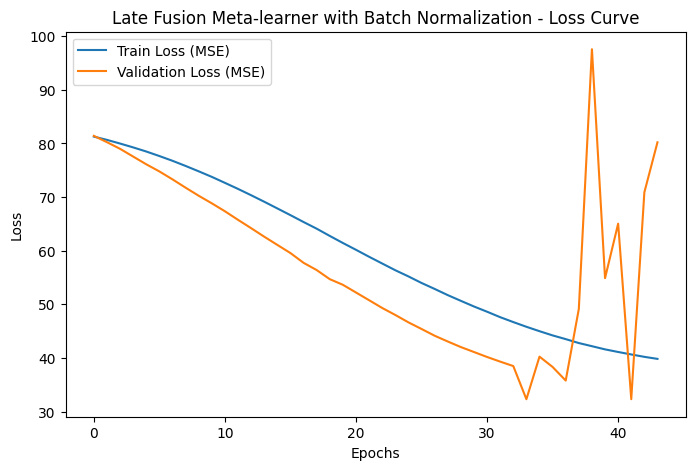

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping

# Paths (update if needed)
audio_train_path = '/kaggle/input/features/train_audio_features_normalized (1).csv'
text_train_path = '/kaggle/input/features/train_standardized.csv'
audio_dev_path = '/kaggle/input/features/fixed_dev_audio_features.csv'
text_dev_path = '/kaggle/input/features/dev_standardized.csv'
audio_test_path = '/kaggle/input/features/fixed_test_audio_features.csv'
text_test_path = '/kaggle/input/features/test_standardized.csv'

# Load datasets
audio_train = pd.read_csv(audio_train_path)
text_train = pd.read_csv(text_train_path)
audio_dev = pd.read_csv(audio_dev_path)
text_dev = pd.read_csv(text_dev_path)
audio_test = pd.read_csv(audio_test_path)
text_test = pd.read_csv(text_test_path)

# Merge on filename to align
train = pd.merge(audio_train, text_train, on='filename', suffixes=('_audio', '_text'))
dev = pd.merge(audio_dev, text_dev, on='filename', suffixes=('_audio', '_text'))
test = pd.merge(audio_test, text_test, on='filename', suffixes=('_audio', '_text'))

all_label_cols = [col for col in train.columns if 'label' in col]
exclude_cols = ['filename'] + all_label_cols

common_cols = set(train.columns) & set(dev.columns) & set(test.columns)
feature_cols = [col for col in common_cols if col not in exclude_cols]

audio_feature_cols = [c for c in feature_cols if c.endswith('_audio')]
text_feature_cols = [c for c in feature_cols if c.endswith('_text')]

X_audio_train = train[audio_feature_cols].values
X_text_train = train[text_feature_cols].values
y_train = train[all_label_cols[0]].values

X_audio_val = dev[audio_feature_cols].values
X_text_val = dev[text_feature_cols].values
y_val = dev[all_label_cols[0]].values

X_audio_test = test[audio_feature_cols].values
X_text_test = test[text_feature_cols].values
y_test = test[all_label_cols[0]].values

# Build independent audio model (not changed here)
audio_input = Input(shape=(X_audio_train.shape[1],), name='audio_input')
x_audio = Dense(128, activation='relu')(audio_input)
x_audio = Dense(64, activation='relu')(x_audio)
audio_output = Dense(1, activation='linear', name='audio_output')(x_audio)
audio_model = Model(audio_input, audio_output)
audio_model.compile(optimizer='adam', loss='mse')

audio_model.fit(
    X_audio_train, y_train,
    validation_data=(X_audio_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=2
)

# Build independent text model (no change)
text_input = Input(shape=(X_text_train.shape[1],), name='text_input')
x_text = Dense(128, activation='relu')(text_input)
x_text = Dense(64, activation='relu')(x_text)
text_output = Dense(1, activation='linear', name='text_output')(x_text)
text_model = Model(text_input, text_output)
text_model.compile(optimizer='adam', loss='mse')

text_model.fit(
    X_text_train, y_train,
    validation_data=(X_text_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=2
)

# Generate predictions for meta-learner training
audio_train_preds = audio_model.predict(X_audio_train)
text_train_preds = text_model.predict(X_text_train)
meta_X_train = np.concatenate([audio_train_preds, text_train_preds], axis=1)

audio_val_preds = audio_model.predict(X_audio_val)
text_val_preds = text_model.predict(X_text_val)
meta_X_val = np.concatenate([audio_val_preds, text_val_preds], axis=1)

audio_test_preds = audio_model.predict(X_audio_test)
text_test_preds = text_model.predict(X_text_test)
meta_X_test = np.concatenate([audio_test_preds, text_test_preds], axis=1)

# Build meta-learner with Batch Normalization
meta_input = Input(shape=(2,), name='meta_input')
x = Dense(16, use_bias=False)(meta_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(8, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
meta_output = Dense(1, activation='linear')(x)

meta_model = Model(meta_input, meta_output)
meta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = meta_model.fit(
    meta_X_train, y_train,
    validation_data=(meta_X_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=2
)

# Evaluate
y_pred = meta_model.predict(meta_X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Meta-learner Test MSE: {mse:.4f}")
print(f"Meta-learner Test MAE: {mae:.4f}")
print(f"Meta-learner Test R2: {r2:.4f}")

# Plot meta-learner loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Late Fusion Meta-learner with Batch Normalization - Loss Curve')
plt.legend()
plt.show()


Epoch 1/100
16/16 - 9s - 557ms/step - loss: 81.4212 - mae: 6.6636 - val_loss: 75.0606 - val_mae: 6.5428
Epoch 2/100
16/16 - 0s - 8ms/step - loss: 81.2071 - mae: 6.6524 - val_loss: 74.8553 - val_mae: 6.5322
Epoch 3/100
16/16 - 0s - 7ms/step - loss: 80.9963 - mae: 6.6413 - val_loss: 74.6473 - val_mae: 6.5213
Epoch 4/100
16/16 - 0s - 7ms/step - loss: 80.7894 - mae: 6.6300 - val_loss: 74.4393 - val_mae: 6.5105
Epoch 5/100
16/16 - 0s - 7ms/step - loss: 80.5806 - mae: 6.6190 - val_loss: 74.2338 - val_mae: 6.4997
Epoch 6/100
16/16 - 0s - 7ms/step - loss: 80.3754 - mae: 6.6078 - val_loss: 74.0351 - val_mae: 6.4893
Epoch 7/100
16/16 - 0s - 8ms/step - loss: 80.1709 - mae: 6.5971 - val_loss: 73.8351 - val_mae: 6.4788
Epoch 8/100
16/16 - 0s - 7ms/step - loss: 79.9682 - mae: 6.5862 - val_loss: 73.6362 - val_mae: 6.4683
Epoch 9/100
16/16 - 0s - 7ms/step - loss: 79.7664 - mae: 6.5753 - val_loss: 73.4410 - val_mae: 6.4580
Epoch 10/100
16/16 - 0s - 7ms/step - loss: 79.5663 - mae: 6.5645 - val_loss: 73.

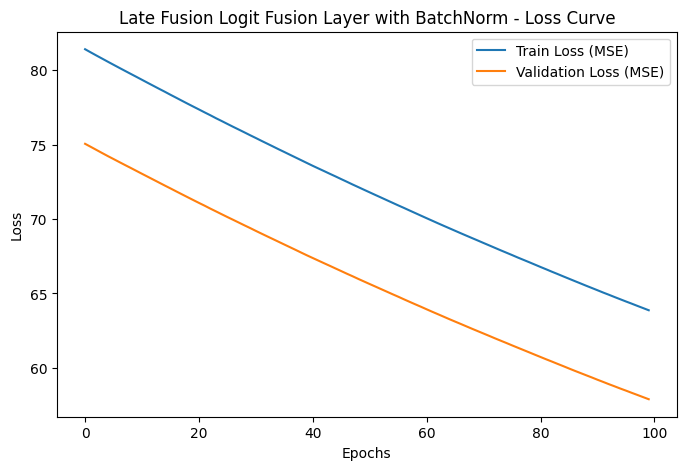

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Paths (adjust if needed)
audio_train_path = '/kaggle/input/features/train_audio_features_normalized (1).csv'
text_train_path = '/kaggle/input/features/train_standardized.csv'
audio_dev_path = '/kaggle/input/features/fixed_dev_audio_features.csv'
text_dev_path = '/kaggle/input/features/dev_standardized.csv'
audio_test_path = '/kaggle/input/features/fixed_test_audio_features.csv'
text_test_path = '/kaggle/input/features/test_standardized.csv'

# Load and merge as before
audio_train = pd.read_csv(audio_train_path)
text_train = pd.read_csv(text_train_path)
audio_dev = pd.read_csv(audio_dev_path)
text_dev = pd.read_csv(text_dev_path)
audio_test = pd.read_csv(audio_test_path)
text_test = pd.read_csv(text_test_path)

train = pd.merge(audio_train, text_train, on='filename', suffixes=('_audio', '_text'))
dev = pd.merge(audio_dev, text_dev, on='filename', suffixes=('_audio', '_text'))
test = pd.merge(audio_test, text_test, on='filename', suffixes=('_audio', '_text'))

all_label_cols = [col for col in train.columns if 'label' in col]
exclude_cols = ['filename'] + all_label_cols

train_cols = set(train.columns)
dev_cols = set(dev.columns)
test_cols = set(test.columns)
common_cols = train_cols & dev_cols & test_cols
feature_cols = [col for col in common_cols if col not in exclude_cols]

audio_feature_cols = [c for c in feature_cols if c.endswith('_audio')]
text_feature_cols = [c for c in feature_cols if c.endswith('_text')]

X_audio_train = train[audio_feature_cols].values
X_text_train = train[text_feature_cols].values
y_train = train[all_label_cols[0]].values

X_audio_val = dev[audio_feature_cols].values
X_text_val = dev[text_feature_cols].values
y_val = dev[all_label_cols[0]].values

X_audio_test = test[audio_feature_cols].values
X_text_test = test[text_feature_cols].values
y_test = test[all_label_cols[0]].values

# Audio branch without output layer (logits)
audio_input = Input(shape=(X_audio_train.shape[1],), name='audio_input')
x_audio = Dense(128, activation='relu')(audio_input)
x_audio = Dense(64, activation='relu')(x_audio)
audio_logits = Dense(32, use_bias=False)(x_audio)
audio_logits = BatchNormalization()(audio_logits)
audio_logits = Activation('relu')(audio_logits)

# Text branch without output layer (logits)
text_input = Input(shape=(X_text_train.shape[1],), name='text_input')
x_text = Dense(128, activation='relu')(text_input)
x_text = Dense(64, activation='relu')(x_text)
text_logits = Dense(32, use_bias=False)(x_text)
text_logits = BatchNormalization()(text_logits)
text_logits = Activation('relu')(text_logits)

# Concatenate logits for fusion
fusion = Concatenate(name='fusion_layer')([audio_logits, text_logits])  # shape (batch_size, 64)

# Logit fusion dense layers with batch normalization
x = Dense(32, use_bias=False)(fusion)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(16, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Output layer
output = Dense(1, activation='linear')(x)

model = Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    [X_audio_train, X_text_train], y_train,
    validation_data=([X_audio_val, X_text_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
y_pred = model.predict([X_audio_test, X_text_test])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Late Fusion Logit Fusion Test MSE: {mse:.4f}")
print(f"Late Fusion Logit Fusion Test MAE: {mae:.4f}")
print(f"Late Fusion Logit Fusion Test R2: {r2:.4f}")

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Late Fusion Logit Fusion Layer with BatchNorm - Loss Curve')
plt.legend()
plt.show()


Epoch 1/100
16/16 - 2s - 124ms/step - loss: 81.4154 - val_loss: 75.0571
Epoch 2/100
16/16 - 0s - 6ms/step - loss: 81.2047 - val_loss: 74.8480
Epoch 3/100
16/16 - 0s - 6ms/step - loss: 80.9928 - val_loss: 74.6428
Epoch 4/100
16/16 - 0s - 6ms/step - loss: 80.7824 - val_loss: 74.4385
Epoch 5/100
16/16 - 0s - 6ms/step - loss: 80.5782 - val_loss: 74.2339
Epoch 6/100
16/16 - 0s - 6ms/step - loss: 80.3721 - val_loss: 74.0301
Epoch 7/100
16/16 - 0s - 6ms/step - loss: 80.1635 - val_loss: 73.8276
Epoch 8/100
16/16 - 0s - 6ms/step - loss: 79.9572 - val_loss: 73.6271
Epoch 9/100
16/16 - 0s - 6ms/step - loss: 79.7534 - val_loss: 73.4255
Epoch 10/100
16/16 - 0s - 6ms/step - loss: 79.5467 - val_loss: 73.2290
Epoch 11/100
16/16 - 0s - 6ms/step - loss: 79.3497 - val_loss: 73.0240
Epoch 12/100
16/16 - 0s - 6ms/step - loss: 79.1414 - val_loss: 72.8275
Epoch 13/100
16/16 - 0s - 6ms/step - loss: 78.9405 - val_loss: 72.6277
Epoch 14/100
16/16 - 0s - 6ms/step - loss: 78.7386 - val_loss: 72.4318
Epoch 15/100


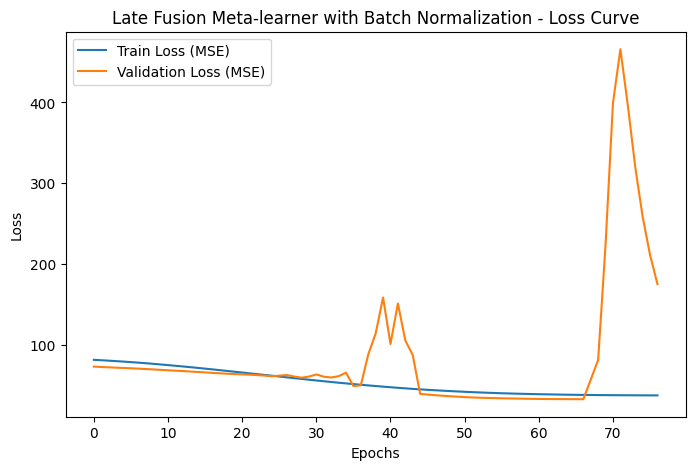

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Paths to your CSVs (update these if needed)
audio_train_path = '/kaggle/input/features/train_audio_features_normalized (1).csv'
text_train_path = '/kaggle/input/features/train_standardized.csv'
audio_dev_path = '/kaggle/input/features/fixed_dev_audio_features.csv'
text_dev_path = '/kaggle/input/features/dev_standardized.csv'
audio_test_path = '/kaggle/input/features/fixed_test_audio_features.csv'
text_test_path = '/kaggle/input/features/test_standardized.csv'

# Load dataframes and merge on filename
audio_train = pd.read_csv(audio_train_path)
text_train = pd.read_csv(text_train_path)
audio_dev = pd.read_csv(audio_dev_path)
text_dev = pd.read_csv(text_dev_path)
audio_test = pd.read_csv(audio_test_path)
text_test = pd.read_csv(text_test_path)

train = pd.merge(audio_train, text_train, on='filename', suffixes=('_audio', '_text'))
dev = pd.merge(audio_dev, text_dev, on='filename', suffixes=('_audio', '_text'))
test = pd.merge(audio_test, text_test, on='filename', suffixes=('_audio', '_text'))

all_label_cols = [col for col in train.columns if 'label' in col]
exclude_cols = ['filename'] + all_label_cols

common_cols = set(train.columns) & set(dev.columns) & set(test.columns)
feature_cols = [col for col in common_cols if col not in exclude_cols]

audio_feature_cols = [c for c in feature_cols if c.endswith('_audio')]
text_feature_cols = [c for c in feature_cols if c.endswith('_text')]

X_audio_train = train[audio_feature_cols].values
X_text_train = train[text_feature_cols].values
y_train = train[all_label_cols[0]].values

X_audio_val = dev[audio_feature_cols].values
X_text_val = dev[text_feature_cols].values
y_val = dev[all_label_cols[0]].values

X_audio_test = test[audio_feature_cols].values
X_text_test = test[text_feature_cols].values
y_test = test[all_label_cols[0]].values

# Build audio and text base models (unchanged, no batchnorm needed here)
audio_input = Input(shape=(X_audio_train.shape[1],))
x_audio = Dense(128, activation='relu')(audio_input)
x_audio = Dense(64, activation='relu')(x_audio)
audio_output = Dense(1)(x_audio)
audio_model = Model(audio_input, audio_output)
audio_model.compile(optimizer='adam', loss='mse')

audio_model.fit(
    X_audio_train, y_train,
    validation_data=(X_audio_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=2
)

text_input = Input(shape=(X_text_train.shape[1],))
x_text = Dense(128, activation='relu')(text_input)
x_text = Dense(64, activation='relu')(x_text)
text_output = Dense(1)(x_text)
text_model = Model(text_input, text_output)
text_model.compile(optimizer='adam', loss='mse')

text_model.fit(
    X_text_train, y_train,
    validation_data=(X_text_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=2
)

# Predictions for meta-learner training
audio_train_preds = audio_model.predict(X_audio_train)
text_train_preds = text_model.predict(X_text_train)
meta_X_train = np.concatenate([audio_train_preds, text_train_preds], axis=1)

audio_val_preds = audio_model.predict(X_audio_val)
text_val_preds = text_model.predict(X_text_val)
meta_X_val = np.concatenate([audio_val_preds, text_val_preds], axis=1)

audio_test_preds = audio_model.predict(X_audio_test)
text_test_preds = text_model.predict(X_text_test)
meta_X_test = np.concatenate([audio_test_preds, text_test_preds], axis=1)

# Meta-learner with Batch Normalization
meta_input = Input(shape=(2,), name='meta_input')
x = Dense(16, use_bias=False)(meta_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(8, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
meta_output = Dense(1, activation='linear')(x)

meta_model = Model(meta_input, meta_output)
meta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = meta_model.fit(
    meta_X_train, y_train,
    validation_data=(meta_X_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=2
)

# Evaluate meta-learner on test
y_pred = meta_model.predict(meta_X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Meta-learner Test MSE: {mse:.4f}")
print(f"Meta-learner Test MAE: {mae:.4f}")
print(f"Meta-learner Test R2: {r2:.4f}")

# Plot meta-learner loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Late Fusion Meta-learner with Batch Normalization - Loss Curve')
plt.legend()
plt.show()
